Бутстрап предоставляет возможность оценить стандартное отклонение и построить доверительные интервалы для метрик, для которых не существует статистических критериев.


Шаги алгоритма:

1. Создаем пары подвыборок, каждая из которых имеет тот же размер, что и исходные данные, для контрольной и экспериментальной групп.
2. Вычисляем метрики для каждой из групп.
3. Рассчитываем разницу между метриками и сохраняем эту разность.
4. Повторяем шаги 1-3 от 1000 до 10000 раз.
5. Строим доверительный интервал с уровнем значимости альфа.
6. Если ноль не попадает в доверительный интервал, то различия статистически значимы на уровне значимости альфа, в противном случае различия не являются статистически значимыми.

Доверительный интервал будем использовать нормальный и перцептильный.

1. Нормальный доверительный интервал имеют формулу $P( \bar{pe} \pm z \cdot \frac{\sigma}{\sqrt{n}}) \geq 1 - \alpha$, где:
    * $\bar{pe}$ - точечная оценка по истинной выборке
    * $z$ - квантиль нормального распределения
    * $\frac{\sigma}{\sqrt{n}}$ - стандартная ошибка среднего, для метрик, посчитанных на основе бутстрап выборок нужно посчитать только среднеквадратическое отклонение
    * $\alpha$ - вероятность ошибки первого рода

2. Чтобы посчитать перцентильный доверительный интервал, нужно отбросить крайние значения $\alpha/2$ и $1-\alpha/2$.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

In [9]:
def normal_ci(pe, bootstrap_sample, alpha=0.05):
    """
    Нормальный доверительный интервал
    """
    z_quantile = stats.norm().ppf(1 - alpha / 2)
    se = np.std(bootstrap_sample)
    left, right = pe - z_quantile * se, pe + z_quantile * se
    return left, right


def percentile_ci(bootstrap_sample, alpha=0.05):
    """
    Перцентильный доверительный интервал
    """
    left, right = np.quantile(bootstrap_sample, [alpha/2, 1-alpha/2])
    return left, right

In [13]:
# В качестве примера, мы создадим две выборки размера 1000 из нормального 
# распределения и вычислим разницу между 0.99-м квантилем.

n = 1000
a_sample = np.random.normal(loc=11, scale=4, size=n)
b_sample = np.random.normal(loc=11, scale=2, size=n)

# точечная оценка для разницы квантилей
pe = np.quantile(b_sample, 0.99) - np.quantile(a_sample, 0.99) 

# количество генерируемых подвыборок, оптимально 1000-10000
B = 5000 

# генерируем выборки с возвращением
bootstrap_a_sample = np.random.choice(a_sample, size=(B, n), replace=True)
bootstrap_b_sample = np.random.choice(b_sample, size=(B, n), replace=True)

# считаем 0.99 квантиль для каждой подвыборки
bootstrap_a_metrics = np.quantile(bootstrap_a_sample, 0.99, axis=1)
bootstrap_b_metrics = np.quantile(bootstrap_b_sample, 0.99, axis=1)

# считаем разницу квантилей
bootstrap_pe = bootstrap_b_metrics - bootstrap_a_metrics

In [71]:
# остается посчитать доверительный интервал для точечной оценки

n_left, n_right = normal_ci(pe, bootstrap_pe)
p_left, p_right = percentile_ci(bootstrap_pe)

normal_ci_result = 'не отвергаем' if n_left < 0 < n_right else 'отвергаем'
percentile_ci_result = 'не отвергаем' if p_left < 0 < p_right else 'отвергаем'

print(f'На основе нормального доверительного интервала гипотезу {normal_ci_result}.\n'
        f'На основе перцентильного доверительного интервала гипотезу {percentile_ci_result}.\n\n'

        f'Согласно нормального ДИ, истинное значение лежит в интервале {n_left:0.2f} - {n_right:0.2f}\n'
        f'и {p_left:0.2f} - {p_right:0.2f} согласно перцентильго ДИ.'
)

На основе нормального доверительного интервала гипотезу отвергаем.
На основе перцентильного доверительного интервала гипотезу отвергаем.

Согласно нормального ДИ, истинное значение лежит в интервале -6.55 - -3.95
и -6.63 - -4.16 согласно перцентильго ДИ.


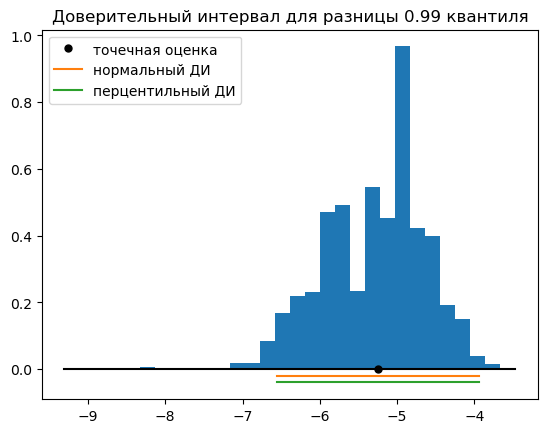

In [68]:
# визуализируем полученные результаты

plt.hist(bootstrap_pe, bins=30, density=True)

plt.plot(pe, 0, 'o', c='black', markersize=5, label='точечная оценка')

p = 0.02
plt.plot([n_left, n_right], [-p, -p], label='нормальный ДИ')
plt.plot([n_left, n_right], [-p*2, -p*2], label='перцентильный ДИ')
plt.plot([bootstrap_pe.min(), bootstrap_pe.max()], [0, 0], c='black')

plt.title('Доверительный интервал для разницы 0.99 квантиля')
plt.legend()

plt.show();